In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy.sparse import hstack
import eli5
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler 
from sklearn.preprocessing import OneHotEncoder
import re
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.special import softmax
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold,StratifiedShuffleSplit
from catboost import Pool
import lightgbm as lgb
from bayes_opt import BayesianOptimization
import xgboost as xgb

/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


In [2]:
%%time
PATH_TO_DATA = '../input/mlcourse-dota2-win-prediction/'
PATH_TO_ADD_DATA = '../input/data-november-18/'
PATH_TO_WINRATES = '../input/winrates/'

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             'train_features.csv'), 
                                    index_col='match_id_hash')
df_train_add_features = pd.read_csv(os.path.join(PATH_TO_ADD_DATA, 
                                             'train_matches_add.csv'), 
                                    index_col='match_id_hash')
df_train_winrates = pd.read_csv(os.path.join(PATH_TO_WINRATES, 
                                             'train_hero_win_rates.csv'), 
                                    index_col='match_id_hash')
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            'train_targets.csv'), 
                                   index_col='match_id_hash')
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_features.csv'), 
                                   index_col='match_id_hash')
df_test_add_features = pd.read_csv(os.path.join(PATH_TO_ADD_DATA, 'test_matches_add.csv'), 
                                   index_col='match_id_hash')
df_test_winrates = pd.read_csv(os.path.join(PATH_TO_WINRATES, 
                                             'test_hero_win_rates.csv'), 
                                    index_col='match_id_hash')

df_train_all_features = pd.concat([df_train_features,df_train_add_features,df_train_winrates],axis=1)
df_test_all_features = pd.concat([df_test_features,df_test_add_features,df_test_winrates],axis=1)

#y_pred_sheregeda = pd.read_csv('../input/catboost-sheregeda/submission.csv', index_col='match_id_hash')
#y_pred_oksana = pd.read_csv('../input/submits/submission_oksana.csv', index_col='match_id_hash')
#y_pred_maxim = pd.read_csv('../input/submits/submission_maxim.csv', index_col='match_id_hash')

df_train_all_features['target'] = df_train_targets['radiant_win']
y_train = df_train_targets['radiant_win']

CPU times: user 8.94 s, sys: 1.76 s, total: 10.7 s
Wall time: 10.5 s


In [3]:
numeric_features = ['kills', 'deaths', 'assists', 'denies', 'gold', 'xp', 'health', 'max_health', 'max_mana', 'level', 
                    'stuns', 'creeps_stacked', 'camps_stacked', 'lh', 'rune_pickups', 'firstblood_claimed', 'last_rune_t', 'last_kill_t', 'last_purchase_t',
                    'teamfight_participation','obs_placed','sen_placed', 'n_abil_uses','life_state_0','life_state_1', 'n_purchases_before_0', 
                    'life_state_2','n_nearby_creep_deaths','n_items_bought', 'damage_dealt', 'damage_taken', 'n_kill_streaks', 'n_purchases_after_0',
                    'n_multi_kills', 'n_heals', 'buybacks', 'max_hit', 'v_lh', 'n_actions', 'health_percent', 'damage_to_neutrals',
                    'v_gold','v_xp','randomed','pings','1st_rune_t','1st_kill_t','1st_puchase_t','pred_vict']
noob_features = ['xp', 'deaths', 'life_state_1', 'life_state_2','n_purchases_before_0', 'n_actions']

In [4]:
def n_support_heros(row, thr):
    n = 0
    for i in row:
        if i>thr:
            n = n+1
    return n

def n_lane_heros(row, team, lane):
    n = 0    
    for i in range(5):
        x = row[i]
        y = row[i+5]
        
        if team == 'dire':
            if lane == 'top':
                if hero_on_dir_top([x,y])==1:
                    n = n+1
            if lane == 'bot':
                if hero_on_dir_bot([x,y])==1:
                    n = n+1
            if lane == 'mid':
                if hero_on_dir_middle([x,y])==1:
                    n = n+1
                    
        if team == 'radiant':
            if lane == 'top':
                if hero_on_rad_top([x,y])==1:
                    n = n+1
            if lane == 'bot':
                if hero_on_rad_bot([x,y])==1:
                    n = n+1
            if lane == 'mid':
                if hero_on_rad_middle([x,y])==1:
                    n = n+1
    return n

def hero_on_rad_bot(entry):
    x = entry[0]
    y = entry[1]
    yes = 0
    if (110 < x < 180 and 72 < y < 84) or (165 < x < 180 and 80 < y < 100):
        yes = 1
    return yes

def hero_on_dir_bot(entry):
    x = entry[0]
    y = entry[1]
    yes = 0
    if (165 < x < 180 and 100 < y < 140):
        yes = 1
    return yes

def hero_on_rad_top(entry):
    x = entry[0]
    y = entry[1]
    yes = 0
    if (70 < x < 85 and 110 < y < 150):
        yes = 1
    return yes

def hero_on_dir_top(entry):
    x = entry[0]
    y = entry[1]
    yes = 0
    if (70 < x < 82 and 145 < y < 180) or (80 < x < 130 and 160 < y < 180):
        yes = 1
    return yes

def hero_on_rad_middle(entry):
    x = entry[0]
    y = entry[1]
    yes = 0
    if (x < y + 10 and x > y - 10 and x+2*y < 370 and x+2*y > 290):
        yes = 1
    return yes

def hero_on_dir_middle(entry):
    x = entry[0]
    y = entry[1]
    yes = 0
    if (x < y + 10 and x > y - 10 and x+2*y > 370 and x+2*y < 442):
        yes = 1
    return yes

def count_kills(x, seconds):
    game_time = x[1]
    kills = x[0]
    n = 0
    if kills != []:
        n = len(np.where(np.array(kills) > (game_time-seconds))[0])
    return n

def count_heros_on_radiant_side(x):
    n = 0
    for i in range(5):
        if x[i]+2*x[i+5] < 370:
            n += 1
    return n

def count_heros_near_radiant_fountain(x):
    n = 0
    for i in range(5):
        if x[i]+2*x[i+5] < 300:
            n += 1
    return n

def count_heros_near_roshan(x):
    n = 0
    for i in range(5):
        if 95 < x[i] < 120 and 130 < x[i+5] < 155:
            n += 1
    return n

def make_hero_pairs(x):
    heros = x.split()
    pairs = ''
    #print(len(heros))
    for i in range(1,5):
        h1 = heros[i-1]
        for j in range(i+1,6):
            h2 = heros[j-1]
            pair = sort_heros(str(h1) + ' ' + str(h2))
            pairs = pairs + pair + ' '
    return x + ' ' + pairs

def make_hero_contr_pairs(x):
    r_heros = x[0].split()
    d_heros = x[1].split()
    pairs = ''
    #print(len(heros))
    for i in range(5):
        h1 = r_heros[i]
        for j in range(5):
            h2 = d_heros[j]
            pair = sort_heros(str(h1) + ' ' + str(h2))
            pairs = pairs + pair + ' '
    return pairs

def count_inventory_items(x):
    n = 0
    for i in x.split():
        if i != 'empty':
            n += 1
    return n

def obs_near_radiant_fountain(entry):
    N = 0
    if entry != [['']]:
        for obs in entry:
            x = int(obs[1])
            y = int(obs[2])
            if (x + y) < 220:
                N += 1
    return N

def obs_near_dire_fountain(entry):
    N = 0
    if entry != [['']]:
        for obs in entry:
            x = int(obs[1])
            y = int(obs[2])
            if (x + y) > 290:
                N += 1
    return N

def r_ward_av_distance(entry):
    d = 0
    if entry != [['']] and entry != []:
        for obs in entry:
            x = int(obs[1])
            y = int(obs[2])
            d = d + (x**2 + y**2)**0.5
        d = d/len(entry)
    else: d = 120
    return d

def d_ward_av_distance(entry):
    d = 0
    if entry != [['']] and entry != []:
        for obs in entry:
            x = int(obs[1])
            y = int(obs[2])
            d = d + (x**2 + y**2)**0.5
        d = d/len(entry)
    else: d = 260
    return d

def calc_left_wards_of_types(df, idx, team, ward_type):
    lefts = []
    for i in df.at[idx, f'{team}_{ward_type}_log']:
        if df.at[idx, f'{team}_{ward_type}_van_log'][0][0] == '':
            lefts = df.at[idx, f'{team}_{ward_type}_log'].copy()
            break
        else:
            gone = 0
            for j in df.at[idx, f'{team}_{ward_type}_van_log']:
                if int(i[1]) == int(j[1]) and int(i[2]) == int(j[2]) and float(i[0])<float(j[0]):
                    gone = gone + 1
            if gone == 0:
                lefts.append(i)
    return lefts
                    
def calculate_left_wards(df):
    df['r_obs_log'] = df['r_obs_log'].apply(lambda x: [i.split(', ') for i in x.strip('[[').strip(']]').split('], [')])
    df['d_obs_log'] = df['d_obs_log'].apply(lambda x: [i.split(', ') for i in x.strip('[[').strip(']]').split('], [')])
    df['r_sen_log'] = df['r_sen_log'].apply(lambda x: [i.split(', ') for i in x.strip('[[').strip(']]').split('], [')])
    df['d_sen_log'] = df['d_sen_log'].apply(lambda x: [i.split(', ') for i in x.strip('[[').strip(']]').split('], [')])
    df['r_obs_van_log'] = df['r_obs_van_log'].apply(lambda x: [i.split(', ') for i in x.strip('[[').strip(']]').split('], [')])
    df['d_obs_van_log'] = df['d_obs_van_log'].apply(lambda x: [i.split(', ') for i in x.strip('[[').strip(']]').split('], [')])
    df['r_sen_van_log'] = df['r_sen_van_log'].apply(lambda x: [i.split(', ') for i in x.strip('[[').strip(']]').split('], [')])
    df['d_sen_van_log'] = df['d_sen_van_log'].apply(lambda x: [i.split(', ') for i in x.strip('[[').strip(']]').split('], [')])
    
    df['r_left_obs_log'] = df['r_obs_log']
    df['d_left_obs_log'] = df['d_obs_log']
    df['r_left_sen_log'] = df['r_sen_log']
    df['d_left_sen_log'] = df['d_sen_log']

    for idx in df.index:

        df.at[idx,'d_left_obs_log'] = calc_left_wards_of_types(df,idx,'d','obs')
        df.at[idx,'r_left_obs_log'] = calc_left_wards_of_types(df,idx,'r','obs')
        df.at[idx,'d_left_sen_log'] = calc_left_wards_of_types(df,idx,'d','sen')
        df.at[idx,'r_left_sen_log'] = calc_left_wards_of_types(df,idx,'r','sen')        

    return df

def does_sentry_see_observer(x):
    sens = x[0]
    obss = x[1]
    see = 0
    if sens != [['']] and sens != [] and obss != [['']] and obss != []:
        for sen in sens:
            for obs in obss:
                dist = ((int(sen[1]) - int(obs[1]))**2 + (int(sen[2]) - int(obs[2]))**2)**0.5
                if dist < 10:
                    see += 1
    return see

In [5]:
def sum_numeric_features(df,features):
    radiant_players = [f'r{i}_' for i in range(1, 6)]
    dire_players = [f'd{i}_' for i in range(1, 6)]
    r_kda = (df['r1_kills']+df['r1_assists']+1)/(df['r1_deaths']+1) + (df['r2_kills']+df['r2_assists']+1)/(df['r2_deaths']+1) + (df['r3_kills']+df['r3_assists']+1)/(df['r3_deaths']+1) + (df['r4_kills']+df['r4_assists']+1)/(df['r4_deaths']+1) + (df['r5_kills']+df['r5_assists']+1)/(df['r5_deaths']+1)
    d_kda = (df['d1_kills']+df['d1_assists']+1)/(df['d1_deaths']+1) + (df['d2_kills']+df['d2_assists']+1)/(df['d2_deaths']+1) + (df['d3_kills']+df['d3_assists']+1)/(df['d3_deaths']+1) + (df['d4_kills']+df['d4_assists']+1)/(df['d4_deaths']+1) + (df['d5_kills']+df['d5_assists']+1)/(df['d5_deaths']+1)
    df['kda_team_difference'] = r_kda - d_kda
    
    for feature in features:
        radiant_feat = [f'{player}{feature}' for player in radiant_players]
        dire_feat = [f'{player}{feature}' for player in dire_players]
        df[f'{feature}_team_difference'] = df[radiant_feat].sum(axis=1) - df[dire_feat].sum(axis=1)         
        df.drop(columns=radiant_feat+dire_feat, inplace=True)
    return df

def detect_noob(df,features):
    radiant_players = [f'r{i}_' for i in range(1, 6)]
    dire_players = [f'd{i}_' for i in range(1, 6)]
    for i in range(1,6):
        df['r%s_noob'%i] = np.zeros(df.shape[0])
        df['d%s_noob'%i] = np.zeros(df.shape[0])
        
    for feature in features:
        radiant_feat = [f'{player}{feature}' for player in radiant_players]
        dire_feat = [f'{player}{feature}' for player in dire_players]
        mean_r =  df[radiant_feat].median(axis=1)
        std_r = df[radiant_feat].std(axis=1)
        mean_d =  df[dire_feat].median(axis=1)
        std_d = df[dire_feat].std(axis=1)
        #WRONG!! DEATH SHOULD BE HIGHR, NOT LOWER
        for i in range(1,6):
            a = ((mean_r - df[f'r{i}_{feature}']) / std_r).apply(lambda x: 1 if x>1 else 0)
            b = ((mean_d - df[f'd{i}_{feature}']) / std_d).apply(lambda x: 1 if x>1 else 0)
            df['r%s_noob'%i] = df['r%s_noob'%i] + a
            df['d%s_noob'%i] = df['d%s_noob'%i] + b          
    return df

def sort_heros(x):
    #print(x)
    odlist = [int(i) for i in x.split(' ')]
    odlist.sort()
    #print(odlist)
    return str(odlist[0]) + '_' + str(odlist[1])

def bin_game_time(x):
    if x<500: return 'A'
    if 500<=x<1000: return 'B'
    if 1000<=x<1500: return 'C'
    if 1500<=x<2000: return 'D'
    if 2000<=x: return 'E'

def count_tpscrolls(items):
    n = 0
    for item in items.split():
        if item == 'item_tpscroll':
            n = n+1
    return n

def calc_consumable_items(items):
    n = 0
    consumables = ['flask', 'tango', 'enchanted_mango', 'tpscroll', 'courier', 'faerie_fire', 'tome_of_knowledge', 'ward_observer', 'clarity', 'bottle', 'smoke_of_deceit',
                   'ward_dispenser','ward_sentry','healing_salve']
    for item in items.split():
        if item in consumables:
            n = n+1
    return n

def victory_percentage(x):
    if x == [] or np.array(x).sum()==0:
        p = 0.5
    else: 
        p = np.array([1 if y>0 else 0 for y in x]).mean()
    return p

def radiant_tf_wins(x):
    if x == []:
        p = 0
    else: 
        p = np.array([1 if y>0 else 0 for y in x]).sum()
    return p

def turn_into_binary(x):
    x_new = []
    for i in x:
        if i>0:
            x_new.append(1)
        if i==0:
            x_new.append(0)
        if i<0:
            x_new.append(-1)
    return x_new

def dire_tf_wins(x):
    if x == []:
        p = 0
    else: 
        p = np.array([1 if y<0 else 0 for y in x]).sum()
    return p

def team_dif_tf_wins(x):
    if x == []:
        p = 0
    else: 
        p = np.array([1 if y>0 else 0 for y in x]).sum() - np.array([1 if y<0 else 0 for y in x]).sum()
    return p

def tf_draw(x):
    if x == []:
        p = 0
    else: 
        p = np.array([1 if y==0 else 0 for y in x]).sum()
    return p

def make_stash(row):
    team_stash = ''
    for stash in row:
        if stash != 'empty':
            team_stash = team_stash + ' ' + stash
    return team_stash

def add_features(df):
    
    df['binned_time'] = df['game_time'].apply(bin_game_time)
    time_shift = df[['player_game_time','game_time']].apply(lambda x: x[0] if x[0] - x[1] > 60 else 0, axis=1)
    df['game_time'] = time_shift + df['game_time']
    
    df['radiant_kill_times'] = df['radiant_kill_times'].apply(lambda x: eval(x))
    df['dire_kill_times'] = df['dire_kill_times'].apply(lambda x: eval(x))
    df['radiant_tower_times'] = df['radiant_tower_times'].apply(lambda x: eval(x))
    df['dire_tower_times'] = df['dire_tower_times'].apply(lambda x: eval(x))
    df['last_1_min_kills_team_diff'] = df[['radiant_kill_times','game_time']].apply(count_kills, args = (60,), axis=1) - df[['dire_kill_times','game_time']].apply(count_kills, args = (60,), axis=1)
    #df['last_2_min_kills_team_diff'] = df[['radiant_kill_times','game_time']].apply(count_kills, args = (120,), axis=1) - df[['dire_kill_times','game_time']].apply(count_kills, args = (120,), axis=1)
    df['last_3_min_kills_team_diff'] = df[['radiant_kill_times','game_time']].apply(count_kills, args = (180,), axis=1) - df[['dire_kill_times','game_time']].apply(count_kills, args = (180,), axis=1)
    df['last_1_min_tower_team_diff'] = df[['radiant_tower_times','game_time']].apply(count_kills, args = (60,), axis=1) - df[['dire_tower_times','game_time']].apply(count_kills, args = (60,), axis=1)
    #df['last_2_min_tower_team_diff'] = df[['radiant_tower_times','game_time']].apply(count_kills, args = (120,), axis=1) - df[['dire_tower_times','game_time']].apply(count_kills, args = (120,), axis=1)
    df['last_3_min_tower_team_diff'] = df[['radiant_tower_times','game_time']].apply(count_kills, args = (180,), axis=1) - df[['dire_tower_times','game_time']].apply(count_kills, args = (180,), axis=1)
    df['radiant_top_towers_damage'] = df['goodguys_tower1_top'] + df['goodguys_tower2_top'] + df['goodguys_tower3_top']
    df['radiant_mid_towers_damage'] = df['goodguys_tower1_mid'] + df['goodguys_tower2_mid'] + df['goodguys_tower3_mid']
    df['radiant_bot_towers_damage'] = df['goodguys_tower1_bot'] + df['goodguys_tower2_bot'] + df['goodguys_tower3_bot']
    df['dire_top_towers_damage'] = df['badguys_tower1_top'] + df['badguys_tower2_top'] + df['badguys_tower3_top']
    df['dire_mid_towers_damage'] = df['badguys_tower1_mid'] + df['badguys_tower2_mid'] + df['badguys_tower3_mid']
    df['dire_bot_towers_damage'] = df['badguys_tower1_bot'] + df['badguys_tower2_bot'] + df['badguys_tower3_bot']
    df['most_damaged_lane_team_difference'] = df[['radiant_top_towers_damage','radiant_mid_towers_damage','radiant_bot_towers_damage']].max(axis=1) - df[['dire_top_towers_damage','dire_mid_towers_damage','dire_bot_towers_damage']].max(axis=1)
    df['damage_home_towers_team_difference'] = df['goodguys_tower4'] - df['badguys_tower4']
    df['most_damaged_tower2_team_difference'] = df[['goodguys_tower2_top','goodguys_tower2_bot','goodguys_tower2_mid']].max(axis=1) - df[['badguys_tower2_top','badguys_tower2_bot','badguys_tower2_mid']].max(axis=1)
    df['most_damaged_tower3_team_difference'] = df[['goodguys_tower3_top','goodguys_tower3_bot','goodguys_tower3_mid']].max(axis=1) - df[['badguys_tower3_top','badguys_tower3_bot','badguys_tower3_mid']].max(axis=1)
    
    df['radiant_heros'] = df[['r%s_hero_id'%i for i in range(1,6)]].apply(lambda row: ' '.join([str(j) for j in row]), axis = 1)
    df['dire_heros'] = df[['d%s_hero_id'%i for i in range(1,6)]].apply(lambda row: ' '.join([str(j) for j in row]), axis = 1)
    
    df['radiant_heros_with_pairs'] = df['radiant_heros'].apply(make_hero_pairs)
    df['dire_heros_with_pairs'] = df['dire_heros'].apply(make_hero_pairs)
    df['heros_contr_pairs'] = df[['radiant_heros','dire_heros']].apply(make_hero_contr_pairs, axis=1)
    df['lobby_type'] = df['lobby_type'].astype('object')
    df['game_mode'] = df['game_mode'].astype('object')
    
    for i in range(1,6):
        df['r%s_hero_id'%i] = df['r%s_hero_id'%i].astype('object')
        df['d%s_hero_id'%i] = df['d%s_hero_id'%i].astype('object')
    
    df['left_obs_team_diff'] =  df['r_left_obs_log'].apply(lambda x: len(x)) - df['d_left_obs_log'].apply(lambda x: len(x))
    df['left_sen_team_diff'] =  df['r_left_sen_log'].apply(lambda x: len(x)) - df['d_left_sen_log'].apply(lambda x: len(x))
    
    df['r_av_distance'] = df[['r%s_x'%i for i in range(1,6)] + ['r%s_y'%i for i in range(1,6)]].apply(lambda x: sum([(x[i]**2+x[i+5]**2)**0.5 for i in range(5)])/5.0, axis=1)
    df['d_av_distance'] = df[['d%s_x'%i for i in range(1,6)] + ['d%s_y'%i for i in range(1,6)]].apply(lambda x: sum([(x[i]**2+x[i+5]**2)**0.5 for i in range(5)])/5.0, axis=1)
    df['sum_of_heros_distances'] =  df['r_av_distance'] + df['d_av_distance']
    df['Penalty_for_heros_on_rad_side'] = df['game_time'].apply(lambda x: x if x>500 else 0) * (-5 + df[['r%s_x'%i for i in range(1,6)] + ['r%s_y'%i for i in range(1,6)]].apply(count_heros_on_radiant_side,axis=1) + df[['d%s_x'%i for i in range(1,6)] + ['d%s_y'%i for i in range(1,6)]].apply(count_heros_on_radiant_side,axis=1))

    df['roshan_kills_team_difference'] = df['r_roshan_kills'] - df['d_roshan_kills']
    df['barrack_kills_team_difference'] = df['r_barracks_kills'] - df['d_barracks_kills']

    categorical_features = df.columns.values[np.where(df.dtypes == 'object')]
    other_features = df.columns.values[np.where(df.dtypes != 'object')]
    df[categorical_features] = df[categorical_features].fillna('empty')
    df[other_features] = df[other_features].fillna(0)

    for i in range(1,6):
        df['r%s_items_used'%i] = df['r%s_items_used'%i].apply(make_item_string)
        df['d%s_items_used'%i] = df['d%s_items_used'%i].apply(make_item_string)
        df['r%s_pred_vict'%i] = df['r%s_pred_vict'%i].map({False: 0, True: 1})
        df['d%s_pred_vict'%i] = df['d%s_pred_vict'%i].map({False: 0, True: 1})
        df['r%s_randomed'%i] = df['r%s_pred_vict'%i].map({False: 0, True: 1})
        df['d%s_randomed'%i] = df['d%s_pred_vict'%i].map({False: 0, True: 1})
        df['r%s_inventory'%i] = df['r%s_inventory'%i].apply(lambda x: str(x).split() + ['empty']*(6-len(str(x).split())))
        df['d%s_inventory'%i] = df['d%s_inventory'%i].apply(lambda x: str(x).split() + ['empty']*(6-len(str(x).split())))
        df['r%s_health_percent'%i] = df['r%s_health'%i] / df['r%s_max_health'%i] 
        df['d%s_health_percent'%i] = df['d%s_health'%i] / df['d%s_max_health'%i] 
 
        df['r%s_1st_rune_t'%i] = df['r%s_1st_rune_t'%i] / (df['game_time'] + 1)
        df['r%s_1st_kill_t'%i] = df['r%s_1st_kill_t'%i] / (df['game_time'] + 1)
        df['r%s_1st_puchase_t'%i] = df['r%s_1st_puchase_t'%i] / (df['game_time'] + 1)
        df['r%s_last_rune_t'%i] = df['r%s_last_rune_t'%i] / (df['game_time'] + 1)
        df['r%s_last_kill_t'%i] = df['r%s_last_kill_t'%i] / (df['game_time'] + 1)
        df['r%s_last_purchase_t'%i] = df['r%s_last_purchase_t'%i] / (df['game_time'] + 1)
        
        df['d%s_1st_rune_t'%i] = df['d%s_1st_rune_t'%i] / (df['game_time'] + 1)
        df['d%s_1st_kill_t'%i] = df['d%s_1st_kill_t'%i] / (df['game_time'] + 1)
        df['d%s_1st_puchase_t'%i] = df['d%s_1st_puchase_t'%i] / (df['game_time'] + 1)
        df['d%s_last_rune_t'%i] = df['d%s_last_rune_t'%i] / (df['game_time'] + 1)
        df['d%s_last_kill_t'%i] = df['d%s_last_kill_t'%i] / (df['game_time'] + 1)
        df['d%s_last_purchase_t'%i] = df['d%s_last_purchase_t'%i] / (df['game_time'] + 1)
        
        for j in range(1,7):
            df[f'r{i}_inventory_c{j}'] = df[f'r{i}_inventory'].apply(lambda x: x[j-1])
            df[f'd{i}_inventory_c{j}'] = df[f'd{i}_inventory'].apply(lambda x: x[j-1])
    
    df['radiant_items'] = df[['r%s_items_used'%i for i in range(1,6)]].apply(lambda row: ' '.join([str(j) for j in row]), axis = 1)
    df['dire_items'] = df[['d%s_items_used'%i for i in range(1,6)]].apply(lambda row: ' '.join([str(j) for j in row]), axis = 1)
    df['n_all_used_items_team_difference'] = df['radiant_items'].apply(lambda x: len(x.split())) - df['dire_items'].apply(lambda x: len(x.split()))
    df['r_team_inventory'] = df[['r%s_inventory'%i for i in range(1,6)]].apply(lambda row: ' '.join([' '.join([str(k) for k in j]) for j in row]), axis = 1)
    df['d_team_inventory'] = df[['d%s_inventory'%i for i in range(1,6)]].apply(lambda row: ' '.join([' '.join([str(k) for k in j]) for j in row]), axis = 1)
    df['radiant_tpscrolls'] = df['r_team_inventory'].apply(count_tpscrolls)
    df['dire_tpscrolls'] = df['d_team_inventory'].apply(count_tpscrolls)
    df['radiant_stash'] = df[['r%s_stash'%i for i in range(1,6)]].apply(make_stash, axis = 1)
    df['dire_stash'] = df[['d%s_stash'%i for i in range(1,6)]].apply(make_stash, axis = 1)
    df['n_inventory_team_difference'] = df['r_team_inventory'].apply(count_inventory_items) - df['d_team_inventory'].apply(count_inventory_items)
    #df['r_team_inventory'] = df['r_team_inventory'] + radiant_stash
    #df['d_team_inventory'] = df['d_team_inventory'] + dire_stash
    df['n_stash_team_difference'] =  df['radiant_stash'].apply(count_inventory_items) - df['dire_stash'].apply(count_inventory_items)
    df['chat_length_team_difference'] = df['r_chat_length'] - df['d_chat_length']
    df['v_purchase_team_difference'] = df['radiant_v_purchase'] - df['dire_v_purchase']
    df['v_runes_team_difference'] = df['radiant_v_runes'] - df['dire_v_runes']
    
    df['radiant_runes'] = df[['r%s_runes'%i for i in range(1,6)]].apply(lambda row: ' '.join([str(j) for j in row]), axis = 1)
    df['dire_runes'] = df[['d%s_runes'%i for i in range(1,6)]].apply(lambda row: ' '.join([str(j) for j in row]), axis = 1)
    
    df['N_obs_r_defense'] = df['r_left_obs_log'].apply(obs_near_radiant_fountain)
    df['N_obs_d_attack'] = df['d_left_obs_log'].apply(obs_near_radiant_fountain)
    df['N_obs_r_attack'] = df['r_left_obs_log'].apply(obs_near_dire_fountain)
    df['N_obs_d_defense'] = df['d_left_obs_log'].apply(obs_near_dire_fountain)
    df['Obs_coord_favor_radiant'] = df['N_obs_r_attack'] + df['N_obs_d_defense'] - df['N_obs_d_attack'] - df['N_obs_r_defense'] 
    
    N_sen_r_defense = df['r_left_sen_log'].apply(obs_near_radiant_fountain)
    N_sen_d_attack = df['d_left_sen_log'].apply(obs_near_radiant_fountain)
    N_sen_r_attack = df['r_left_sen_log'].apply(obs_near_dire_fountain)
    N_sen_d_defense = df['d_left_sen_log'].apply(obs_near_dire_fountain)
    df['Sen_coord_favor_radiant'] = N_sen_r_attack + N_sen_d_defense - N_sen_d_attack - N_sen_r_defense
    
    df['teamfight_results'] = df['teamfight_results'].apply(lambda x: [int(y) for y in x.split(' ')[1:]] if x==x else [])
    df['N_tf_wins_team_difference'] = df['teamfight_results'].apply(team_dif_tf_wins)
    df['Last_fight_result'] = df['teamfight_results'].apply(lambda x: x[-1] if len(x)>0 else 0)
    df['N_tf_draw'] = df['teamfight_results'].apply(tf_draw)
    df['aegis_owners'] = df['aegis_owners'].apply(lambda x: x.split(' ')[1:] if x==x else [])
    
    features_to_drop = ['r%s_towers_killed'%i for i in range(1,6)] + ['d%s_towers_killed'%i for i in range(1,6)] + [
        #'r%s_hero_id'%i for i in range(1,6)] + ['d%s_hero_id'%i for i in range(1,6)] +  
        'r%s_roshans_killed'%i for i in range(1,6)] + ['d%s_roshans_killed'%i for i in range(1,6)] + [
        'r_roshan_kills','d_roshan_kills','r_barracks_kills','d_barracks_kills','r_tower_kills', 
        'd_tower_kills', 'd_av_distance', 'r_av_distance', 'N_obs_r_defense', 
        'N_obs_d_defense', 'N_obs_r_attack', 'N_obs_d_attack','d_chat_length', 'r_chat_length', 
        'radiant_v_purchase','dire_v_purchase', 'dire_v_runes', 'radiant_v_runes', 'goodguys_tower4', 'badguys_tower4', 
        'goodguys_tower1_top', 'goodguys_tower2_top', 'goodguys_tower3_top', 'goodguys_tower1_bot', 'goodguys_tower2_bot', 'goodguys_tower3_bot',
        'goodguys_tower1_mid', 'goodguys_tower2_mid', 'goodguys_tower3_mid', 'badguys_tower1_top', 'badguys_tower2_top', 'badguys_tower3_top',
        'badguys_tower1_mid', 'badguys_tower2_mid', 'badguys_tower3_mid', 'badguys_tower1_bot', 'badguys_tower2_bot', 'badguys_tower3_bot'] + [
        'd%s_x'%i for i in range(1,6)] + ['d%s_y'%i for i in range(1,6)] + [
        'r%s_x'%i for i in range(1,6)] + ['r%s_y'%i for i in range(1,6)] + [
        'r%s_runes'%i for i in range(1,6)] + ['d%s_runes'%i for i in range(1,6)] + [
        'r%s_items_used'%i for i in range(1,6)] + ['d%s_items_used'%i for i in range(1,6)]
    
    df.drop(columns = features_to_drop, inplace=True)
    return df

def make_item_string(item_dict):
    dic = eval(item_dict)
    item_string = ''
    for k, v in dic.items():
        item_string = item_string + ' ' + (k+' ')*v
    return item_string

In [6]:
%%time
df_train_all_features = calculate_left_wards(df_train_all_features)
df_test_all_features = calculate_left_wards(df_test_all_features)

CPU times: user 38.9 s, sys: 700 ms, total: 39.6 s
Wall time: 39.6 s


In [7]:
%%time
print('Starting to process train')
df_train_all_features = add_features(df_train_all_features)
print('Starting to process test')
df_test_all_features = add_features(df_test_all_features)

Starting to process train
Starting to process test
CPU times: user 2min 35s, sys: 7.76 s, total: 2min 43s
Wall time: 2min 40s


In [8]:
%%time
df_train_all_features = sum_numeric_features(df_train_all_features, numeric_features)
df_test_all_features = sum_numeric_features(df_test_all_features, numeric_features)
df_train_all_features['death_duration_team_difference'] = df_train_all_features['life_state_2_team_difference'] + df_train_all_features['life_state_1_team_difference']
df_test_all_features['death_duration_team_difference'] = df_test_all_features['life_state_2_team_difference'] + df_test_all_features['life_state_1_team_difference']
df_train_all_features.drop(columns = ['life_state_2_team_difference', 'life_state_1_team_difference'], inplace=True)
df_test_all_features.drop(columns = ['life_state_2_team_difference', 'life_state_1_team_difference'], inplace=True)

CPU times: user 17.5 s, sys: 9.53 s, total: 27 s
Wall time: 23.4 s


**Logistic regression**

In [9]:
logreg_features = ['radiant_killed_last_roshan', 'radiant_killed_last_barrack','diff_tower_kills', 'last_1_min_kills_team_diff',
       'last_3_min_kills_team_diff', 'last_1_min_tower_team_diff','last_3_min_tower_team_diff', 'kills_team_difference',
       'most_damaged_tower2_team_difference', 'most_damaged_tower3_team_difference', 'left_obs_team_diff',
       'left_sen_team_diff', 'sum_of_heros_distances', 'Penalty_for_heros_on_rad_side', 'roshan_kills_team_difference',
       'barrack_kills_team_difference','n_all_used_items_team_difference', 'n_inventory_team_difference',
       'n_stash_team_difference', 'chat_length_team_difference',  'v_purchase_team_difference', 'v_runes_team_difference',
       'Obs_coord_favor_radiant', 'Sen_coord_favor_radiant', 'N_tf_wins_team_difference', 'Last_fight_result','kda_team_difference', 
       'assists_team_difference', 'denies_team_difference','gold_team_difference', 'max_health_team_difference',
       'max_mana_team_difference', 'level_team_difference','stuns_team_difference', 'creeps_stacked_team_difference',
       'lh_team_difference', 'rune_pickups_team_difference', 'firstblood_claimed_team_difference', 'v_gold_team_difference',
       'teamfight_participation_team_difference','obs_placed_team_difference', 'sen_placed_team_difference',
       'n_abil_uses_team_difference', 'n_purchases_before_0_team_difference', 'n_nearby_creep_deaths_team_difference',
       'damage_dealt_team_difference', 'damage_taken_team_difference','n_kill_streaks_team_difference', 'buybacks_team_difference',
       'n_purchases_after_0_team_difference', 'n_multi_kills_team_difference', 'n_heals_team_difference', 'max_hit_team_difference',
       'v_lh_team_difference', 'n_actions_team_difference',  'health_percent_team_difference', 'damage_to_neutrals_team_difference',
       'v_xp_team_difference', 'pings_team_difference','pred_vict_team_difference']               
                
cat_features_logreg = ['binned_time','game_mode', 'lobby_type']

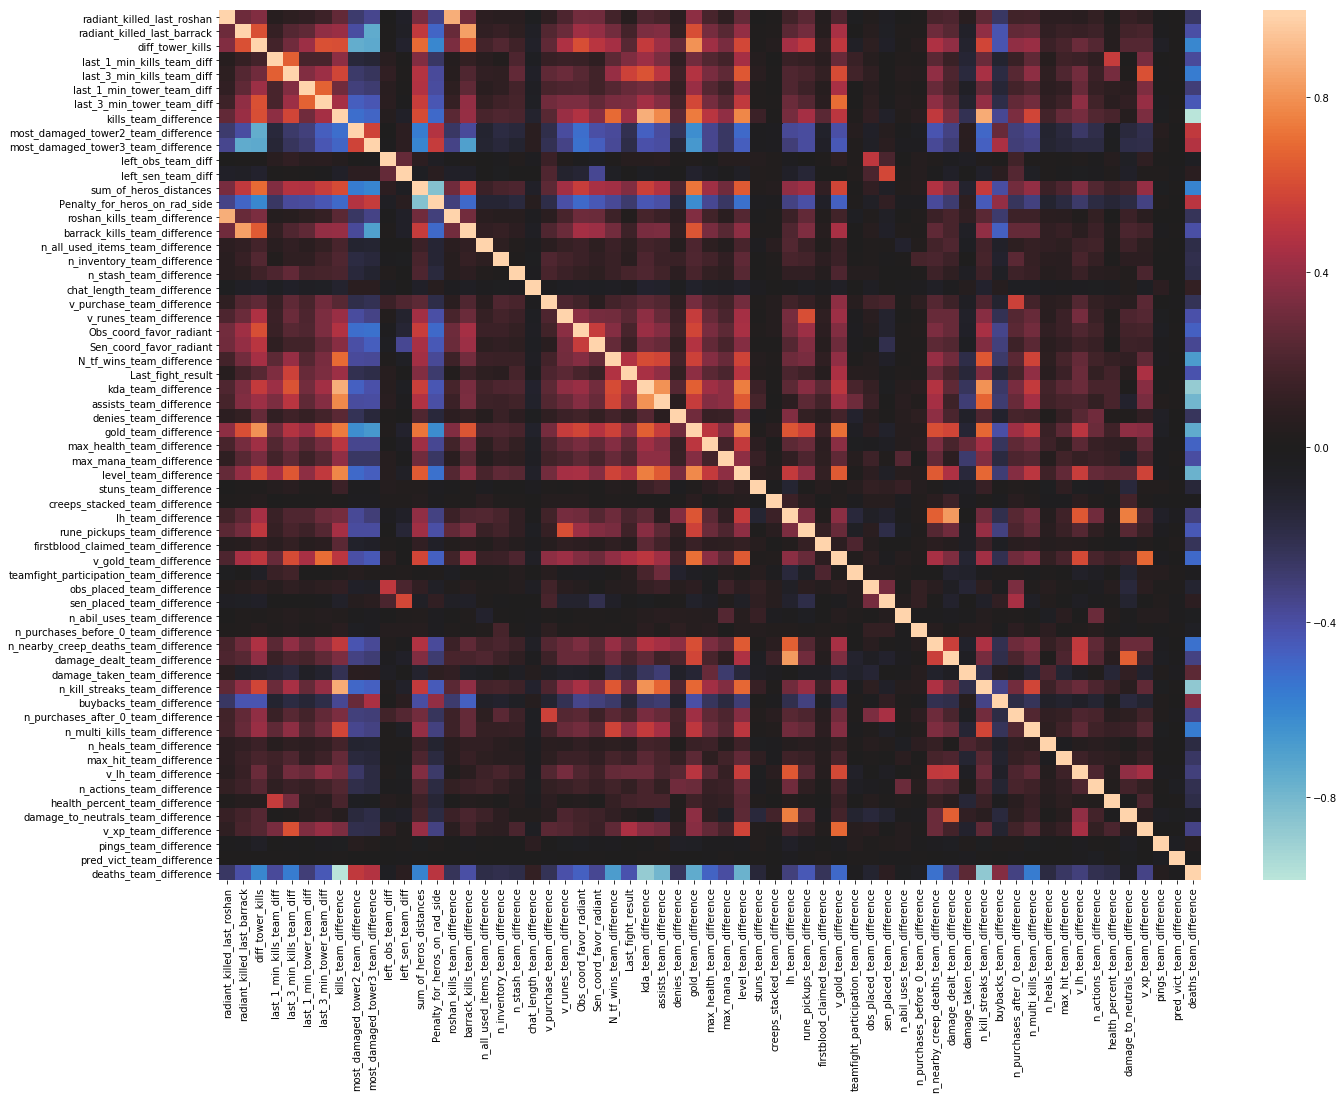

In [10]:
plt.figure(figsize=(22,16))
sns.heatmap(df_train_all_features[logreg_features + ['deaths_team_difference']].corr(method='pearson'),center=0)

In [11]:
radiant_rune_cv = CountVectorizer(ngram_range = (1,1),analyzer="word", token_pattern=u"(?u)\\b\\w+\\b")
radiant_train_runes = radiant_rune_cv.fit_transform(df_train_all_features['radiant_runes'].tolist()).todense()
radiant_test_runes = radiant_rune_cv.transform(df_test_all_features['radiant_runes'].tolist()).todense()
dire_train_runes = radiant_rune_cv.transform(df_train_all_features['dire_runes'].tolist()).todense()
dire_test_runes = radiant_rune_cv.transform(df_test_all_features['dire_runes'].tolist()).todense()

train_runes_diff = radiant_train_runes - dire_train_runes
test_runes_diff = radiant_test_runes - dire_test_runes

radiant_inventory_cv = CountVectorizer(ngram_range = (1,1),analyzer="word", token_pattern=u"(?u)\\b\\w+\\b")
radiant_train_inventory = radiant_inventory_cv.fit_transform(df_train_all_features['r_team_inventory'].tolist()).todense()
radiant_test_inventory = radiant_inventory_cv.transform(df_test_all_features['r_team_inventory'].tolist()).todense()
dire_train_inventory = radiant_inventory_cv.transform(df_train_all_features['d_team_inventory'].tolist()).todense()
dire_test_inventory = radiant_inventory_cv.transform(df_test_all_features['d_team_inventory'].tolist()).todense()

train_inventory_diff = radiant_train_inventory - dire_train_inventory
test_inventory_diff = radiant_test_inventory - dire_test_inventory

In [12]:
train_runes_boost = pd.DataFrame(train_runes_diff,index = df_train_all_features.index, columns=['rune1','rune2','rune3','rune4','rune5','rune6','rune7', 'no_runes'])
test_runes_boost = pd.DataFrame(test_runes_diff,index = df_test_all_features.index, columns=['rune1','rune2','rune3','rune4','rune5','rune6','rune7', 'no_runes'])
train_inventory_df = pd.DataFrame(train_inventory_diff,index = df_train_all_features.index, columns=['item_%s'%i for i in range(train_inventory_diff.shape[1])])
test_inventory_df = pd.DataFrame(test_inventory_diff,index = df_test_all_features.index,columns=['item_%s'%i for i in range(train_inventory_diff.shape[1])])

df_train_all_features = pd.concat([df_train_all_features, train_runes_boost],axis=1)
df_test_all_features = pd.concat([df_test_all_features, test_runes_boost],axis=1)

In [13]:
item_features = []
for i in range(train_inventory_df.shape[1]):
    ratio = train_inventory_df[train_inventory_df['item_%s'%i]!=0].shape[0]/train_inventory_df.shape[0]
    print(ratio)
    if ratio>0.05:
        item_features.append('item_%s'%i)

0.8593320730938878
0.04294896030245747
0.05746691871455577
0.02475110270951481
0.18039067422810334
0.1387271581600504
0.5139256458727158
0.1918588531821046
0.04342785129174543
0.09300567107750472
0.045419029615626966
0.2674228103339635
0.1667296786389414
0.21958412098298677
0.08748582230623818
0.07039697542533081
0.22666666666666666
0.3898172652804033
0.049981096408317584
0.036546943919344675
0.5784247006931317
0.05300567107750473
0.4471833648393195
0.10845620667926906
0.36400756143667296
0.02679269061121613
0.02643982356647763
0.058273471959672335
0.06641461877756774
0.015349716446124763
0.1193194706994329
0.3739130434782609
0.03679899180844361
0.08335223692501575
5.040957781978576e-05
0.05620667926906112
0.22812854442344047
0.019054820415879015
0.011039697542533082
0.0077882797731569
0.006603654694391934
0.01653434152488973
0.03193446754883428
0.1670069313169502
0.16862003780718338
0.1642848141146818
0.39105229993698803
0.020718336483931947
0.14497794580970386
0.3457844990548204
0.05

In [14]:
%%time

df_train_for_fit = df_train_all_features.copy()
df_test_for_fit = df_test_all_features.copy()
y_train_for_fit = y_train.copy()
quantile_range = (15,85)
    
scaler = RobustScaler(quantile_range = quantile_range)
df_train_scaled = scaler.fit_transform(df_train_for_fit[logreg_features])
df_test_scaled = scaler.transform(df_test_for_fit[logreg_features])

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df_train_for_fit[cat_features_logreg])
train_cat_sparse = enc.transform(df_train_for_fit[cat_features_logreg])
test_cat_sparse = enc.transform(df_test_for_fit[cat_features_logreg])

scaler = RobustScaler(quantile_range = quantile_range)
train_runes_diff = scaler.fit_transform(train_runes_diff)
test_runes_diff = scaler.transform(test_runes_diff)

radiant_item_cv = CountVectorizer(ngram_range = (1,1),analyzer="word", token_pattern=u"(?u)\\b\\w+\\b")
radiant_train_items = radiant_item_cv.fit_transform(df_train_for_fit['radiant_items'].tolist()).todense()
radiant_test_items = radiant_item_cv.transform(df_test_for_fit['radiant_items'].tolist()).todense()
dire_train_items = radiant_item_cv.transform(df_train_for_fit['dire_items'].tolist()).todense()
dire_test_items = radiant_item_cv.transform(df_test_for_fit['dire_items'].tolist()).todense()

train_items_diff = radiant_train_items - dire_train_items
test_items_diff = radiant_test_items - dire_test_items

scaler = RobustScaler(quantile_range = quantile_range)
train_items_diff = scaler.fit_transform(train_items_diff)
test_items_diff = scaler.transform(test_items_diff)

scaler = RobustScaler(quantile_range = quantile_range)
train_inventory_diff = scaler.fit_transform(train_inventory_diff)
test_inventory_diff = scaler.transform(test_inventory_diff)

radiant_hero_cv = CountVectorizer(ngram_range = (1,1),analyzer="word", token_pattern=u"(?u)\\b\\w+\\b")
radiant_train_heros = radiant_hero_cv.fit_transform(df_train_for_fit['radiant_heros_with_pairs'].tolist())
radiant_test_heros = radiant_hero_cv.transform(df_test_for_fit['radiant_heros_with_pairs'].tolist())

dire_hero_cv = CountVectorizer(ngram_range = (1,1),analyzer="word", token_pattern=u"(?u)\\b\\w+\\b")
dire_train_heros = dire_hero_cv.fit_transform(df_train_for_fit['dire_heros_with_pairs'].tolist())
dire_test_heros = dire_hero_cv.transform(df_test_for_fit['dire_heros_with_pairs'].tolist())

CPU times: user 26.4 s, sys: 328 ms, total: 26.7 s
Wall time: 26.6 s


In [15]:
X_train = hstack([radiant_train_heros, dire_train_heros, df_train_scaled, train_cat_sparse, train_runes_diff, train_items_diff, train_inventory_diff])
X_test = hstack([radiant_test_heros, dire_test_heros, df_test_scaled, test_cat_sparse, test_runes_diff, test_items_diff, test_inventory_diff])

In [16]:
%%time

logit = LogisticRegression(C=0.0096, random_state=17, solver='lbfgs', max_iter=2000) #if does not converge, increase max iterations! 0.21544
cv_scores = cross_val_score(logit, X_train, y_train_for_fit, cv=5, 
                                scoring='roc_auc', n_jobs=4)
logit.fit(X_train,y_train_for_fit)
y_pred_logreg = logit.predict_proba(X_test)[:, 1]
eli5.show_weights(estimator=logit, feature_names= 
                  ["r " + i for i in radiant_hero_cv.get_feature_names()] + 
                  ["d " + j for j in dire_hero_cv.get_feature_names()] + logreg_features
                  #["rd " + j for j in contr_hero_cv.get_feature_names()] +
                  #+ ['synergy','contrgy'] 
                  + enc.get_feature_names().tolist() 
                  + radiant_rune_cv.get_feature_names() 
                  + radiant_item_cv.get_feature_names()
                  + radiant_inventory_cv.get_feature_names()
                  ,top=40)

CPU times: user 33.7 s, sys: 616 ms, total: 34.3 s
Wall time: 47 s


Weight?,Feature
+0.601,level_team_difference
+0.410,kda_team_difference
+0.395,barrack_kills_team_difference
+0.344,gold_team_difference
+0.343,v_lh_team_difference
+0.321,r 67
+0.314,lh_team_difference
+0.313,r 32
+0.279,r 22
+0.269,item_radiance


In [17]:
cv_scores, cv_scores.mean(), cv_scores.std()

(array([0.84423106, 0.84469098, 0.84503329, 0.8409579 , 0.84772904]),
 0.8445284538054132,
 0.002161588909218561)

In [18]:
feature_coef_dict = dict(zip(logreg_features +
                             enc.get_feature_names().tolist() + 
                             radiant_rune_cv.get_feature_names() + 
                             radiant_item_cv.get_feature_names() + 
                             radiant_inventory_cv.get_feature_names(), 
                             logit.coef_[0][radiant_train_heros.shape[1]+dire_train_heros.shape[1]:X_train.shape[1]]))

In [19]:
feature_coef_df = pd.DataFrame.from_dict(feature_coef_dict,orient='index',columns=['feature'])
feature_coef_df['sign'] = feature_coef_df['feature'].apply(lambda x: np.sign(x))
feature_coef_df['feature'] = feature_coef_df['feature'].abs()
feature_coef_df.sort_values(by='feature',ascending=False)[0:40]

,feature,sign
level_team_difference,0.601289,1.0
kda_team_difference,0.410046,1.0
barrack_kills_team_difference,0.395353,1.0
gold_team_difference,0.343639,1.0
v_lh_team_difference,0.342588,1.0
lh_team_difference,0.314195,1.0
item_radiance,0.269077,1.0
denies_team_difference,0.261150,1.0
diff_tower_kills,0.253113,1.0
max_health_team_difference,0.237689,1.0


**CATBOOST**

In [20]:
df_train_all_features['game_mode'] = df_train_all_features['game_mode'].astype('object')
df_train_all_features['lobby_type'] = df_train_all_features['lobby_type'].astype('object')
df_test_all_features['game_mode'] = df_test_all_features['game_mode'].astype('object')
df_test_all_features['lobby_type'] = df_test_all_features['lobby_type'].astype('object')
for i in range(1,6):
    df_train_all_features['r%s_hero_id'%i] = df_train_all_features['r%s_hero_id'%i].astype('object')
    df_train_all_features['d%s_hero_id'%i] = df_train_all_features['d%s_hero_id'%i].astype('object')
    df_test_all_features['r%s_hero_id'%i] = df_test_all_features['r%s_hero_id'%i].astype('object')
    df_test_all_features['d%s_hero_id'%i] = df_test_all_features['d%s_hero_id'%i].astype('object')
for i in range(1,11):
    df_train_all_features['r_pair_%s'%i] = df_train_all_features['radiant_heros_with_pairs'].apply(lambda x: x.split()[i+4])
    df_train_all_features['d_pair_%s'%i] = df_train_all_features['dire_heros_with_pairs'].apply(lambda x: x.split()[i+4])
    df_test_all_features['r_pair_%s'%i] = df_test_all_features['radiant_heros_with_pairs'].apply(lambda x: x.split()[i+4])
    df_test_all_features['d_pair_%s'%i] = df_test_all_features['dire_heros_with_pairs'].apply(lambda x: x.split()[i+4])

catboost_features = ['game_mode', 'lobby_type', 'objectives_len', 'chat_len','radiant_killed_last_roshan',            
       'radiant_killed_last_tower', 'radiant_killed_last_barrack','diff_tower_kills', 'N_teamfights', 'game_time',
       'last_1_min_kills_team_diff', 'last_3_min_kills_team_diff','last_1_min_tower_team_diff', 'last_3_min_tower_team_diff',
       'most_damaged_lane_team_difference','damage_home_towers_team_difference',
       'most_damaged_tower2_team_difference','most_damaged_tower3_team_difference', 'left_obs_team_diff',
       'left_sen_team_diff', 'sum_of_heros_distances','Penalty_for_heros_on_rad_side', 'roshan_kills_team_difference',
       'barrack_kills_team_difference','n_all_used_items_team_difference', 'n_inventory_team_difference',
       'n_stash_team_difference', 'chat_length_team_difference','v_purchase_team_difference', 'v_runes_team_difference',
       'Obs_coord_favor_radiant', 'Sen_coord_favor_radiant','N_tf_wins_team_difference', 'Last_fight_result', 'N_tf_draw',
       'kda_team_difference', 'kills_team_difference','deaths_team_difference', 'assists_team_difference',
       'denies_team_difference', 'gold_team_difference','xp_team_difference', 'health_team_difference',
       'max_health_team_difference', 'max_mana_team_difference','level_team_difference', 'stuns_team_difference',
       'creeps_stacked_team_difference', 'camps_stacked_team_difference', 'lh_team_difference', 'rune_pickups_team_difference',
       'firstblood_claimed_team_difference','last_rune_t_team_difference', 'last_kill_t_team_difference','last_purchase_t_team_difference',
       'teamfight_participation_team_difference','obs_placed_team_difference', 'sen_placed_team_difference',
       'n_abil_uses_team_difference', 'life_state_0_team_difference','n_purchases_before_0_team_difference',
       'n_nearby_creep_deaths_team_difference','n_items_bought_team_difference', 'damage_dealt_team_difference',
       'damage_taken_team_difference', 'n_kill_streaks_team_difference','n_purchases_after_0_team_difference',
       'n_multi_kills_team_difference', 'n_heals_team_difference','buybacks_team_difference', 'max_hit_team_difference',
       'v_lh_team_difference', 'n_actions_team_difference','health_percent_team_difference',
       'contr_pair_2_1', 'contr_pair_2_2','contr_pair_2_3', 'contr_pair_2_4', 'contr_pair_2_5', 'contr_pair_3_1', 'contr_pair_3_2', 'contr_pair_3_3',
       'contr_pair_3_4', 'contr_pair_3_5', 'contr_pair_4_1', 'contr_pair_4_2',
       'contr_pair_4_3', 'contr_pair_4_4', 'contr_pair_4_5', 'contr_pair_5_1', 'contr_pair_5_2', 'contr_pair_5_3',
       'contr_pair_5_4', 'contr_pair_5_5', 'contr_pair_1_1', 'contr_pair_1_2', 'contr_pair_1_3',
       'contr_pair_1_4', 'contr_pair_1_5',             
       'damage_to_neutrals_team_difference', 'v_gold_team_difference', 'v_xp_team_difference', 'randomed_team_difference',
       'pings_team_difference', '1st_rune_t_team_difference','1st_kill_t_team_difference', '1st_puchase_t_team_difference',
       'pred_vict_team_difference', 'death_duration_team_difference',
       'r_pair_1_2', 'd_pair_1_2', 'r_pair_1_3','d_pair_1_3', 'r_pair_1_4', 'd_pair_1_4', 'r_pair_1_5','d_pair_1_5',
       'r_pair_2_3', 'd_pair_2_3', 'r_pair_2_4', 'd_pair_2_4', 'r_pair_2_5', 'd_pair_2_5',
       'r_pair_3_4', 'd_pair_3_4', 'r_pair_3_5', 'd_pair_3_5', 'r_pair_4_5', 'd_pair_4_5',
       'r1_hero', 'd1_hero', 'r2_hero', 'd2_hero', 'r3_hero', 'd3_hero', 'r4_hero', 'd4_hero','r5_hero', 'd5_hero',
       'rune1','rune2','rune3','rune4','rune5','rune6','rune7', 'no_runes']

X_train_ctb = df_train_all_features[catboost_features]
X_test_ctb = df_test_all_features[catboost_features]
categ_feat_idx_ctb = np.where(X_train_ctb.dtypes == 'object')[0]

In [21]:
n_fold = 5 # amount of data folds
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=17)

params_catboost = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed': 17,
          'early_stopping_rounds': 200,
          'iterations': 1000,
          'task_type': 'CPU'
         }

test_data = Pool(data=X_test_ctb,
                 cat_features=categ_feat_idx_ctb)

scores = []
ctb_test_pred = np.zeros(X_test_ctb.shape[0])
for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train_ctb, y_train)):
    
    X_train_skf, X_valid_skf = X_train_ctb.iloc[train_index], X_train_ctb.iloc[valid_index] # train and validation data splits
    y_train_skf, y_valid_skf = y_train.map({False:0, True:1})[train_index], y_train.map({False:0, True:1})[valid_index]
    
    train_data = Pool(data=X_train_skf, 
                      label=y_train_skf,
                      cat_features=categ_feat_idx_ctb)
    valid_data = Pool(data=X_valid_skf, 
                      label=y_valid_skf,
                      cat_features=categ_feat_idx_ctb)
    
    model = CatBoostClassifier(**params_catboost)
    model.fit(train_data,
              eval_set=valid_data, 
              use_best_model=True
             )
    
    score = model.get_best_score()['validation']['AUC']
    scores.append(score)

    y_pred = model.predict_proba(test_data)[:, 1]
    ctb_test_pred += y_pred

y_pred_catboost = ctb_test_pred / n_fold
print('CV mean: {:.4f}, CV std: {:.4f}'.format(np.mean(scores), np.std(scores)))

Learning rate set to 0.112181
0:	test: 0.7971541	best: 0.7971541 (0)	total: 130ms	remaining: 2m 9s
200:	test: 0.8477981	best: 0.8481677 (132)	total: 12.3s	remaining: 48.7s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8481676856
bestIteration = 132

Shrink model to first 133 iterations.
Learning rate set to 0.112181
0:	test: 0.7948959	best: 0.7948959 (0)	total: 67.2ms	remaining: 1m 7s
200:	test: 0.8370884	best: 0.8378763 (130)	total: 12.3s	remaining: 48.7s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8378763283
bestIteration = 130

Shrink model to first 131 iterations.
Learning rate set to 0.112181
0:	test: 0.7966557	best: 0.7966557 (0)	total: 64.9ms	remaining: 1m 4s
200:	test: 0.8351636	best: 0.8354958 (136)	total: 12.2s	remaining: 48.7s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8354958111
bestIteration = 136

Shrink model to first 137 iterations.
Learning rate set to 0.112181
0:	test: 0.7900617	best: 0.7900617 

**LightGBM**

In [22]:
df_train_all_features['game_mode'] = df_train_all_features['game_mode'].astype('int')
df_train_all_features['lobby_type'] = df_train_all_features['lobby_type'].astype('int')
df_test_all_features['game_mode'] = df_test_all_features['game_mode'].astype('int')
df_test_all_features['lobby_type'] = df_test_all_features['lobby_type'].astype('int')
    
lgbm_features = ['game_time', 'game_mode', 'lobby_type','radiant_killed_last_roshan', 'radiant_killed_last_tower',
       'radiant_killed_last_barrack', 'diff_tower_kills', 'N_teamfights','r1_hero', 'd1_hero', 'r_pair_1_2', 'd_pair_1_2', 'r_pair_1_3',
       'd_pair_1_3', 'r_pair_1_4', 'd_pair_1_4', 'r_pair_1_5','d_pair_1_5', 'contr_pair_1_1', 'contr_pair_1_2', 'contr_pair_1_3',
       'contr_pair_1_4', 'contr_pair_1_5', 'r2_hero', 'd2_hero','r_pair_2_3', 'd_pair_2_3', 'r_pair_2_4', 'd_pair_2_4',
       'r_pair_2_5', 'd_pair_2_5', 'contr_pair_2_1', 'contr_pair_2_2','contr_pair_2_3', 'contr_pair_2_4', 'contr_pair_2_5', 'r3_hero',
       'd3_hero', 'r_pair_3_4', 'd_pair_3_4', 'r_pair_3_5', 'd_pair_3_5','contr_pair_3_1', 'contr_pair_3_2', 'contr_pair_3_3',
       'contr_pair_3_4', 'contr_pair_3_5', 'r4_hero', 'd4_hero','r_pair_4_5', 'd_pair_4_5', 'contr_pair_4_1', 'contr_pair_4_2',
       'contr_pair_4_3', 'contr_pair_4_4', 'contr_pair_4_5', 'r5_hero','d5_hero', 'contr_pair_5_1', 'contr_pair_5_2', 'contr_pair_5_3',
       'contr_pair_5_4', 'contr_pair_5_5', 'last_1_min_kills_team_diff','last_3_min_kills_team_diff', 'last_1_min_tower_team_diff',
       'last_3_min_tower_team_diff', 'most_damaged_lane_team_difference','damage_home_towers_team_difference','most_damaged_tower2_team_difference',
       'most_damaged_tower3_team_difference', 'left_obs_team_diff','left_sen_team_diff', 'sum_of_heros_distances',
       'Penalty_for_heros_on_rad_side', 'roshan_kills_team_difference','barrack_kills_team_difference',
       'n_all_used_items_team_difference', 'n_inventory_team_difference','n_stash_team_difference', 'chat_length_team_difference',
       'v_purchase_team_difference', 'v_runes_team_difference','Obs_coord_favor_radiant', 'Sen_coord_favor_radiant',
       'N_tf_wins_team_difference', 'Last_fight_result', 'N_tf_draw','kda_team_difference', 'kills_team_difference',
       'deaths_team_difference', 'assists_team_difference','denies_team_difference', 'gold_team_difference','xp_team_difference', 'health_team_difference',
       'max_health_team_difference', 'max_mana_team_difference','level_team_difference', 'stuns_team_difference','creeps_stacked_team_difference', 
       'camps_stacked_team_difference','lh_team_difference', 'rune_pickups_team_difference','firstblood_claimed_team_difference',
       'last_rune_t_team_difference', 'last_kill_t_team_difference','last_purchase_t_team_difference','teamfight_participation_team_difference',
       'obs_placed_team_difference', 'sen_placed_team_difference','n_abil_uses_team_difference', 'life_state_0_team_difference',
       'n_purchases_before_0_team_difference','n_nearby_creep_deaths_team_difference','n_items_bought_team_difference', 'damage_dealt_team_difference',
       'damage_taken_team_difference', 'n_kill_streaks_team_difference','n_purchases_after_0_team_difference','n_multi_kills_team_difference', 'n_heals_team_difference',
       'buybacks_team_difference', 'max_hit_team_difference','v_lh_team_difference', 'n_actions_team_difference','health_percent_team_difference',
       'damage_to_neutrals_team_difference', 'v_gold_team_difference','v_xp_team_difference', 'randomed_team_difference',
       'pings_team_difference', '1st_rune_t_team_difference','1st_kill_t_team_difference', '1st_puchase_t_team_difference',
       'pred_vict_team_difference', 'death_duration_team_difference']

X_train_lgb = df_train_all_features[lgbm_features]
X_test_lgb = df_test_all_features[lgbm_features]
X_train_lgb = pd.concat([X_train_lgb, train_inventory_df[item_features]],axis=1)
X_test_lgb = pd.concat([X_test_lgb, test_inventory_df[item_features]],axis=1)
categ_feat_idx = [1,2]
df_train_all_features[lgbm_features].columns.values[categ_feat_idx]

array(['game_mode', 'lobby_type'], dtype=object)

In [23]:
def lgb_eval(num_leaves,max_depth,lambda_l2,lambda_l1, min_data_in_leaf):
    params = {
    "objective" : "binary",
    "metric" : "auc", 
    'is_unbalance': False,
    "num_leaves" : int(num_leaves),
    "max_depth" : int(max_depth),
    "lambda_l2" : lambda_l2,
    "lambda_l1" : lambda_l1,
    "num_threads" : 0,
    'min_data_in_leaf': int(min_data_in_leaf),
    "learning_rate" : 0.03,
    "subsample_freq" : 5,
    "bagging_seed" : 42,
    "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(X_train_lgb, y_train, categorical_feature=categ_feat_idx) #categorical contents must be integer for some reason! they slow everything down@ remove them!
    cv_result = lgb.cv(params,
                       lgtrain,
                       10000,
                       early_stopping_rounds=300,
                       stratified=True,
                       nfold=5)
    return cv_result['auc-mean'][-1]

def lgb_train_v(num_leaves,max_depth,lambda_l2,lambda_l1, min_data_in_leaf):
    params = {
    "objective" : "binary",
    "metric" : "auc", 
    'is_unbalance': False,
    "num_leaves" : int(num_leaves),
    "max_depth" : int(max_depth),
    "lambda_l2" : lambda_l2,
    "lambda_l1" : lambda_l1,
    "num_threads" : 0,
    'min_data_in_leaf': int(min_data_in_leaf),
    "learning_rate" : 0.03,
    "subsample_freq" : 5,
    "bagging_seed" : 42,
    "verbosity" : -1
    }
    t_x,v_x,t_y,v_y = train_test_split(X_train_lgb, y_train, test_size=0.2)
    lgtrain = lgb.Dataset(t_x, t_y, categorical_feature=categ_feat_idx)
    lgvalid = lgb.Dataset(v_x, v_y, categorical_feature=categ_feat_idx)
    model = lgb.train(params, lgtrain, 4000, valid_sets=[lgvalid], early_stopping_rounds=400, verbose_eval=200)
    pred_test_y = model.predict(X_test_lgb, num_iteration=model.best_iteration)
    return pred_test_y, model

def lgb_train(X_t, y_t, X_v, y_v, num_leaves, max_depth, lambda_l2, lambda_l1, min_data_in_leaf):
    params = {
    "objective" : "binary",
    "metric" : "auc", 
    'is_unbalance': False,
    "num_leaves" : int(num_leaves),
    "max_depth" : int(max_depth),
    "lambda_l2" : lambda_l2,
    "lambda_l1" : lambda_l1,
    "num_threads" : 0,
    'min_data_in_leaf': int(min_data_in_leaf),
    "learning_rate" : 0.03,
    "verbosity" : -1
    }
    lgtrain = lgb.Dataset(X_t, y_t, categorical_feature=categ_feat_idx)
    lgvalid = lgb.Dataset(X_v, y_v, categorical_feature=categ_feat_idx)
    model = lgb.train(params, lgtrain, 4000, valid_sets=[lgvalid], early_stopping_rounds=400, verbose_eval=200)
    pred_test_y = model.predict(X_v, num_iteration=model.best_iteration)
    return pred_test_y

def logreg_train(X_t,y_t,X_v,y_v):
    logit = LogisticRegression(C=0.0096, random_state=17, solver='lbfgs', max_iter=2000)
    logit.fit(X_t,y_t)
    y_pred_logreg = logit.predict_proba(X_v)[:, 1]
    return y_pred_logreg

def catboost_train(X_t,y_t,X_v,y_v):
    ctb = CatBoostClassifier(random_seed=17, verbose=200, eval_metric = 'AUC', early_stopping_rounds=200, iterations=1000, loss_function='Logloss')
    ctb.fit(X_t, y_t.map({False:0, True:1}), eval_set=(X_v, y_v.map({False:0, True:1})), use_best_model=True, cat_features=categ_feat_idx_ctb)
    ctb_valid_pred = ctb.predict_proba(X_v)[:, 1]
    return ctb_valid_pred

def param_tuning(init_points,num_iter,**args):
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (15, 200),
                                                'max_depth': (5, 120),
                                                'lambda_l2': (0.0, 5),
                                                'lambda_l1': (0.0, 5),
                                                'min_data_in_leaf': (5, 500)
                                                })

    lgbBO.maximize(init_points=init_points, n_iter=num_iter,**args)
    return lgbBO

In [24]:
%%time
#result = param_tuning(10,50)
#params = result.max['params']
#params

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.4 µs


In [25]:
params_lgbm = {'lambda_l1': 0.8105333937498804,
          'lambda_l2': 2.561699778373912,
          'max_depth': 93.31302296334526,
          'min_data_in_leaf': 299.119952931138,
          'num_leaves': 15.356236313316968}

In [26]:
%%time
pred_test_y1, _ = lgb_train_v(**params_lgbm)
pred_test_y2, _ = lgb_train_v(**params_lgbm)
pred_test_y3, model = lgb_train_v(**params_lgbm)
y_pred_lgb = (pred_test_y1 + pred_test_y2 + pred_test_y3)/3

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.838239
[400]	valid_0's auc: 0.842029
[600]	valid_0's auc: 0.842614
[800]	valid_0's auc: 0.842843
[1000]	valid_0's auc: 0.842129
Early stopping, best iteration is:
[789]	valid_0's auc: 0.84293
Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.837224
[400]	valid_0's auc: 0.840918
[600]	valid_0's auc: 0.84137
[800]	valid_0's auc: 0.841418
[1000]	valid_0's auc: 0.84111
Early stopping, best iteration is:
[648]	valid_0's auc: 0.841621
Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.836844
[400]	valid_0's auc: 0.840416
[600]	valid_0's auc: 0.840384
[800]	valid_0's auc: 0.840096
Early stopping, best iteration is:
[409]	valid_0's auc: 0.840463
CPU times: user 4min 21s, sys: 3.36 s, total: 4min 24s
Wall time: 1min 8s


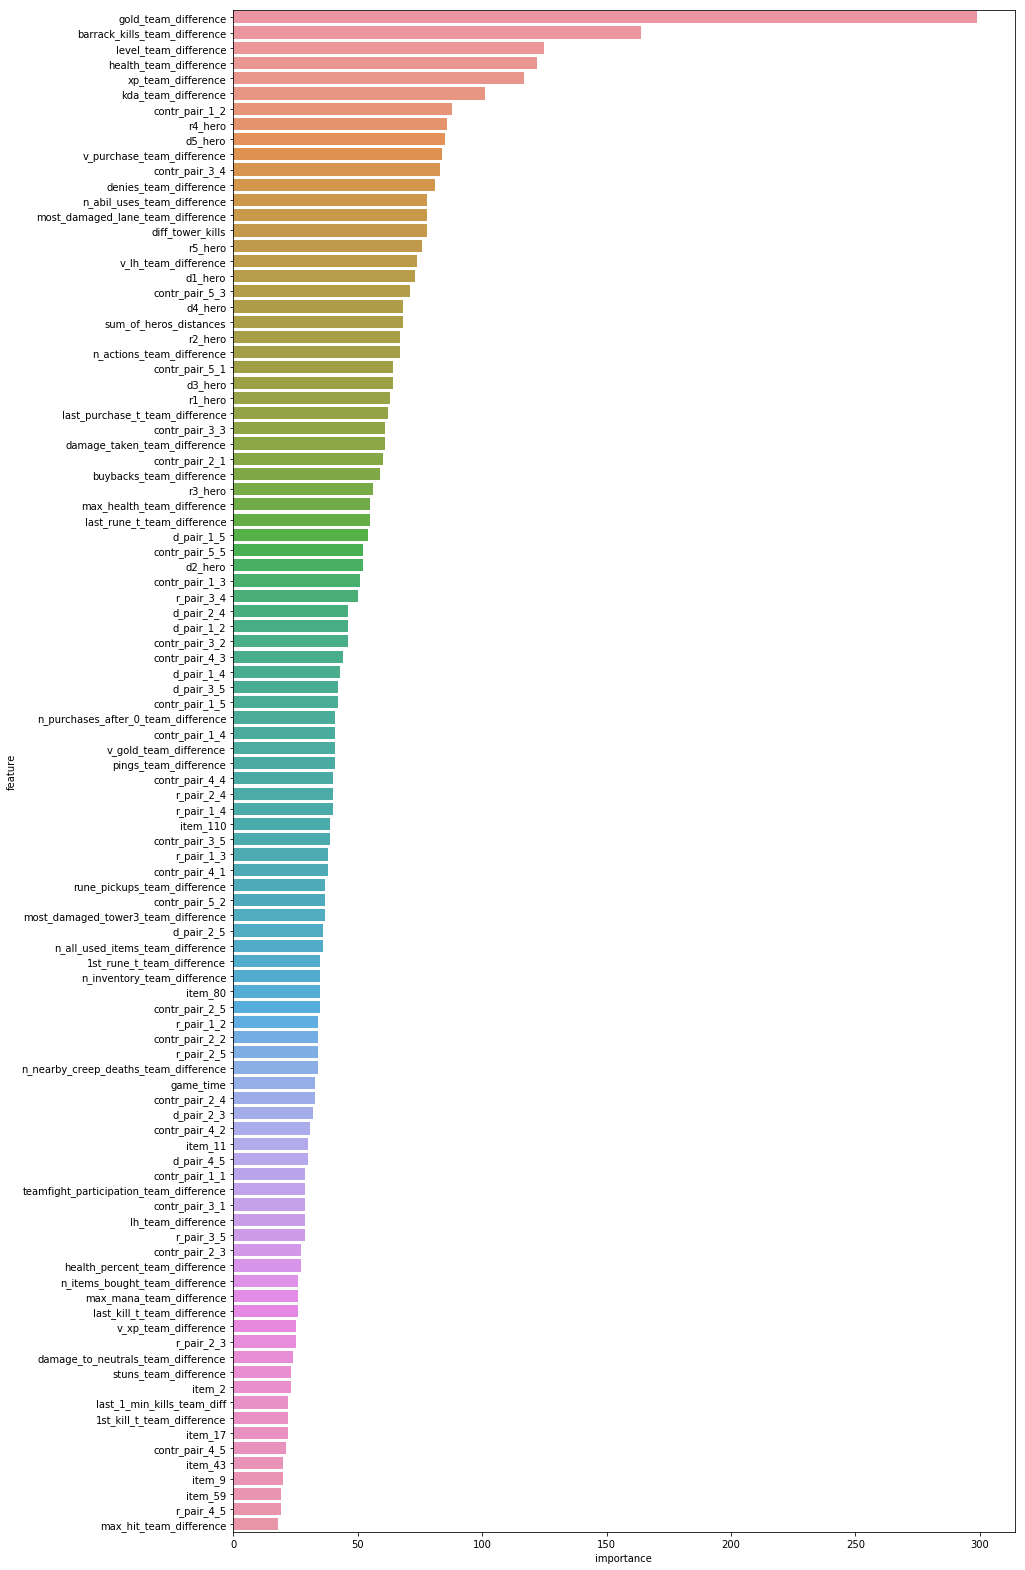

In [27]:
feature_importance = pd.DataFrame({'feature': X_train_lgb.columns, 'importance':model.feature_importance()}).sort_values('importance', ascending=False)[:100]

plt.figure(figsize=(14,28))
sns.barplot(x=feature_importance.importance, y=feature_importance.feature)

In [28]:
%%time
a_list = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
b_list = [1.0,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.0]
fold_roc_aucs = pd.DataFrame()

for i in range(5):
    fold_roc_aucs['Fold%s'%i] = np.nan
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train_ctb, y_train)):
        roc_aucs = []
        a_all, b_all = [], []
        print('Here are radiant win ratios in train and test:', np.array(y_train[train_index]).sum()/len(y_train[train_index]),np.array(y_train[valid_index]/len(y_train[valid_index])).sum())
        y_1 = logreg_train(X_train.tocsr()[train_index], y_train[train_index], X_train.tocsr()[valid_index], y_train[valid_index])
        y_2 = catboost_train(X_train_ctb.iloc[train_index],  y_train[train_index], X_train_ctb.iloc[valid_index], y_train[valid_index])
        y_3 = lgb_train(X_train_lgb.iloc[train_index],y_train[train_index], X_train_lgb.iloc[valid_index], y_train[valid_index], **params_lgbm)
        for i in range(len(a_list)-1):
            for j in range(i+1, len(b_list)):
                y_blending = (1-a_list[i]-b_list[j])*y_1 + a_list[i]*y_2 + b_list[j]*y_3
                roc_aucs.append(roc_auc_score(y_train[valid_index], y_blending))
                a_all.append(a_list[i])
                b_all.append(b_list[j])
        fold_roc_aucs['Fold%s'%fold_n] = roc_aucs
        if fold_n==0:
            fold_roc_aucs['catboost_percent'] = a_all
            fold_roc_aucs['lgbm_percent'] = b_all
fold_roc_aucs['mean'] = fold_roc_aucs[['Fold0','Fold1','Fold2','Fold3','Fold4']].mean(axis=1)
fold_roc_aucs['std'] = fold_roc_aucs[['Fold0','Fold1','Fold2','Fold3','Fold4']].std(axis=1)
fold_roc_aucs.sort_values(by='mean',ascending=False)

Here are radiant win ratios in train and test: 0.5249062667380825 0.5249495967741935
Learning rate set to 0.112181
0:	test: 0.7917644	best: 0.7917644 (0)	total: 66ms	remaining: 1m 5s
200:	test: 0.8416705	best: 0.8416705 (200)	total: 12.3s	remaining: 48.9s
400:	test: 0.8396494	best: 0.8420051 (217)	total: 24.4s	remaining: 36.5s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8420051293
bestIteration = 217

Shrink model to first 218 iterations.


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.839364
[400]	valid_0's auc: 0.843495
[600]	valid_0's auc: 0.843816
[800]	valid_0's auc: 0.843712
Early stopping, best iteration is:
[508]	valid_0's auc: 0.843888
Here are radiant win ratios in train and test: 0.5249212350346566 0.5248897290485192
Learning rate set to 0.112181
0:	test: 0.7907868	best: 0.7907868 (0)	total: 61.9ms	remaining: 1m 1s
200:	test: 0.8326013	best: 0.8327606 (193)	total: 12.3s	remaining: 49.1s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8327605631
bestIteration = 193

Shrink model to first 194 iterations.


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.830688
[400]	valid_0's auc: 0.835331
[600]	valid_0's auc: 0.836783
[800]	valid_0's auc: 0.837062
[1000]	valid_0's auc: 0.837005
Early stopping, best iteration is:
[780]	valid_0's auc: 0.837131
Here are radiant win ratios in train and test: 0.5249212350346566 0.5248897290485193
Learning rate set to 0.112181
0:	test: 0.7991160	best: 0.7991160 (0)	total: 64.7ms	remaining: 1m 4s
200:	test: 0.8431277	best: 0.8442669 (120)	total: 12.4s	remaining: 49.1s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8442668951
bestIteration = 120

Shrink model to first 121 iterations.


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.840794
[400]	valid_0's auc: 0.844389
[600]	valid_0's auc: 0.84475
[800]	valid_0's auc: 0.844622
[1000]	valid_0's auc: 0.844051
Early stopping, best iteration is:
[630]	valid_0's auc: 0.844891
Here are radiant win ratios in train and test: 0.5249212350346566 0.5248897290485192
Learning rate set to 0.112181
0:	test: 0.8004746	best: 0.8004746 (0)	total: 66.8ms	remaining: 1m 6s
200:	test: 0.8387133	best: 0.8396101 (146)	total: 12.4s	remaining: 49.1s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8396100509
bestIteration = 146

Shrink model to first 147 iterations.


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.838922
[400]	valid_0's auc: 0.841349
[600]	valid_0's auc: 0.841341
[800]	valid_0's auc: 0.841238
Early stopping, best iteration is:
[431]	valid_0's auc: 0.841584
Here are radiant win ratios in train and test: 0.524904697394537 0.5249558860599948
Learning rate set to 0.112182
0:	test: 0.7980120	best: 0.7980120 (0)	total: 67.7ms	remaining: 1m 7s
200:	test: 0.8385275	best: 0.8385275 (200)	total: 12.1s	remaining: 48.1s
400:	test: 0.8356138	best: 0.8385535 (201)	total: 24.1s	remaining: 36s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8385534739
bestIteration = 201

Shrink model to first 202 iterations.


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.836344
[400]	valid_0's auc: 0.84001
[600]	valid_0's auc: 0.840291
[800]	valid_0's auc: 0.84029
[1000]	valid_0's auc: 0.83984
Early stopping, best iteration is:
[761]	valid_0's auc: 0.840433
CPU times: user 16min 18s, sys: 50.7 s, total: 17min 8s
Wall time: 5min 4s


,Fold0,Fold1,Fold2,Fold3,Fold4,catboost_percent,lgbm_percent,mean,std
15,0.849647,0.841453,0.851380,0.848469,0.848414,0.1,0.3,0.847872,0.003785
24,0.849699,0.841194,0.851511,0.848441,0.848446,0.2,0.2,0.847858,0.003931
5,0.849417,0.841502,0.851136,0.848406,0.848227,0.0,0.4,0.847738,0.003672
16,0.849436,0.840919,0.851217,0.848528,0.848568,0.1,0.2,0.847734,0.003962
32,0.849652,0.840826,0.851483,0.848346,0.848319,0.3,0.1,0.847725,0.004067
23,0.849638,0.841411,0.851396,0.848098,0.848003,0.2,0.3,0.847709,0.003782
25,0.849457,0.840642,0.851271,0.848468,0.848540,0.2,0.1,0.847675,0.004091
14,0.849509,0.841568,0.851233,0.848109,0.847912,0.1,0.4,0.847666,0.003659
6,0.849250,0.841032,0.851022,0.848465,0.848456,0.0,0.3,0.847645,0.003842
31,0.849627,0.841083,0.851419,0.848019,0.847936,0.3,0.2,0.847617,0.003920


In [29]:
y_final =  0.6*y_pred_logreg + 0.1*y_pred_catboost + 0.3*y_pred_lgb
df_submission = pd.DataFrame({'radiant_win_prob': y_final}, 
                                 index=df_test_all_features.index)
df_submission.to_csv('submission_dota_Oksana_Kovalenko.csv')

from IPython.display import FileLink
FileLink(r'submission_dota_Oksana_Kovalenko.csv')

/kaggle/working/submission_dota_Oksana_Kovalenko.csv

In [30]:
#y_maxim = y_pred_maxim['radiant_win_prob'].values 
#y_oksana = y_pred_oksana['radiant_win_prob'].values 

#y_final =  0.6*y_oksana + 0.4*y_maxim
#df_submission = pd.DataFrame({'radiant_win_prob': y_final}, 
#                                 index=df_test_all_features.index)
#df_submission.to_csv('submission_dota_Oksana_Kovalenko.csv')

#from IPython.display import FileLink
#FileLink(r'submission_dota_Oksana_Kovalenko.csv')